## Import All Libraries

In [1]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [2]:
# Read data and EDA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from wordcloud import WordCloud

# Preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from string import punctuation
from unidecode import unidecode

# Preparation and Evaluation
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Model Implementation
import tensorflow as tf
from tensorflow.keras.metrics import AUC
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Dropout, Embedding, SimpleRNN
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

## Load Data

In [3]:
train_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/train_essays.csv", usecols=['text', 'generated'])
train_essay 

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0
...,...,...
1373,There has been a fuss about the Elector Colleg...,0
1374,Limiting car usage has many advantages. Such a...,0
1375,There's a new trend that has been developing f...,0
1376,As we all know cars are a big part of our soci...,0


In [4]:
test_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/test_essays.csv")
test_essay

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [5]:
sample_sub = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text/sample_submission.csv")
sample_sub

,id,generated
0,0000aaaa,0.1
1,1111bbbb,0.9
2,2222cccc,0.4


## Exploratory Data Analysis (EDA)

In [6]:
train_essay.head()

,text,generated
0,Cars. Cars have been around since they became ...,0
1,Transportation is a large necessity in most co...,0
2,"""America's love affair with it's vehicles seem...",0
3,How often do you ride in a car? Do you drive a...,0
4,Cars are a wonderful thing. They are perhaps o...,0


In [7]:
train_essay.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       1378 non-null   object
 1   generated  1378 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 21.7+ KB


In [8]:
def show_series_count(ser: pd.Series, ser_name: str):
    train_val_count = ser.value_counts().reset_index()
    plt.bar(train_val_count[train_val_count.columns[0]].astype(str), train_val_count['count'])
    plt.xlabel(ser_name)
    plt.title(f'{ser_name} label count')
    [plt.text(lbl, count, count, ha="center", va="bottom") for (lbl, count) in train_val_count.to_numpy()]
    plt.show()

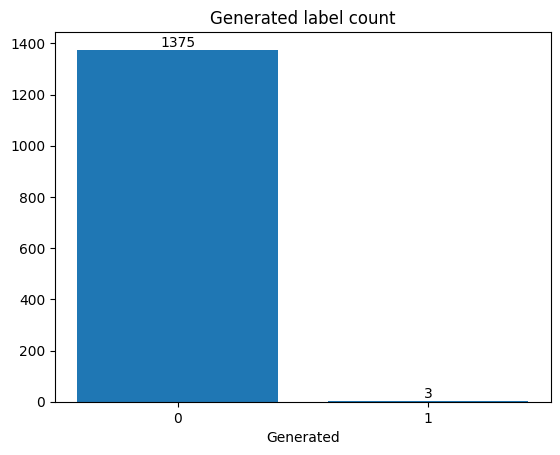

In [9]:
show_series_count(train_essay['generated'], 'Generated')

There is not enough test labels. We will need additional data to train the model.

In [10]:
extra_train_essay = pd.read_csv("/kaggle/input/llm-detect-ai-generated-text-dataset/Training_Essay_Data.csv")
train_essay = pd.concat([train_essay, extra_train_essay], ignore_index=True)

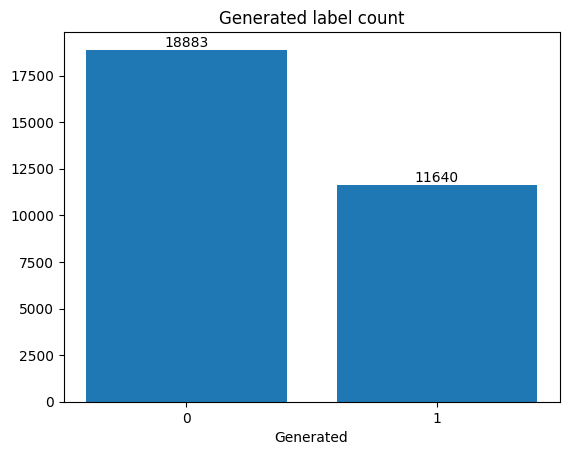

In [11]:
show_series_count(train_essay['generated'], 'Generated')

## Data Pre-processing

In [12]:
def clean_text(paragraphs):
    cleaned = []
    for word in paragraphs:
        lower_case = word.lower()
        if lower_case not in punctuation and lower_case not in stopwords.words('english') and len(word) > 2 and word.isalpha():
            cleaned.append(lower_case)
        else:
            continue
    return cleaned


def lemmatization(paragraphs):
    lemmatizer = WordNetLemmatizer()
    final_text = []
    for i in paragraphs:
        lemma_word = lemmatizer.lemmatize(i)
        final_text.append(lemma_word)
    return " ".join(final_text)


def text_preprocess(texts):
    replaced = texts.apply(lambda t: t.replace("\\n"," ").replace("\t"," "))
    decoded = replaced.apply(unidecode)
    tokenized = decoded.apply(word_tokenize)
    cleaned = tokenized.apply(clean_text)
    final_product = cleaned.apply(lemmatization)
    return final_product

In [13]:
train_text_processed = text_preprocess(train_essay['text'])

In [14]:
train_text_processed

0        car car around since became famous henry ford ...
1        transportation large necessity country worldwi...
2        america love affair vehicle seems cooling say ...
3        often ride car drive one motor vehicle work st...
4        car wonderful thing perhaps one world greatest...
                               ...                        
30518    fuss elector college many people get confused ...
30519    limiting car usage many advantage putting lot ...
30520    new trend developing year soon full throttle a...
30521    know car big part society today however car bi...
30522    car around since popular ever since although r...
Name: text, Length: 30523, dtype: object

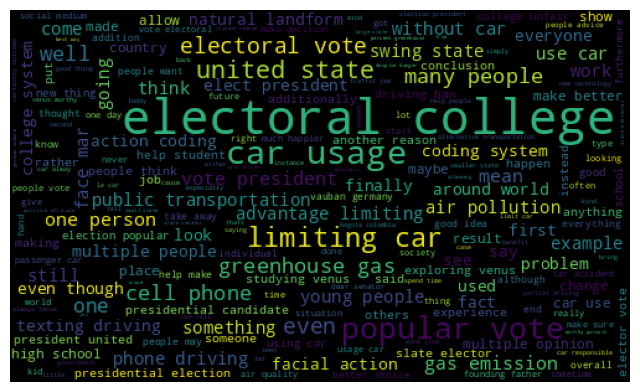

In [15]:
# Convert all articles into single string
word_cloud = train_text_processed.str.cat(sep=" ")
word_cloud = WordCloud(width=500, height=300).generate(word_cloud)
plt.figure(figsize=(8, 8))
plt.imshow(word_cloud)
plt.axis("off")
plt.show()

## Data Split for train and test purpose for base model

In [16]:
x_train, x_val, y_train, y_val = train_test_split(train_text_processed, train_essay['generated'], test_size=0.2, shuffle=True)


In [17]:
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(24418,)
(6105,)
(24418,)
(6105,)


In [18]:
all_train_words = []
for s in x_train:
    all_train_words.extend(s.split())
    
all_train_words = np.unique(all_train_words)

In [19]:
len(all_train_words)

57436

## Word Embedding

In [20]:
max_words = len(all_train_words)
x_train_np = x_train.values
x_val_np = x_val.values
tk = Tokenizer(num_words=max_words, oov_token="oov")
tk.fit_on_texts(x_train_np)

x_train_seq = tk.texts_to_sequences(x_train_np)
x_val_seq = tk.texts_to_sequences(x_val_np)

In [21]:
len(x_train_seq)

24418

In [22]:
lst = []
for i in range(0, len(x_train_seq)):
    a = len(x_train_seq[i])
    lst.append(a)

print("Max length of text:", max(lst))
print("Min length of text:", min(lst))

Max length of text: 878
Min length of text: 0


In [23]:
max_len = max(lst)
x_train_padded = pad_sequences(x_train_seq, maxlen=max_len, padding="post", truncating="post")
x_val_padded = pad_sequences(x_val_seq, maxlen=max_len, padding="post", truncating="post")

In [24]:
print(x_train_padded.shape)
print(x_val_padded.shape)

(24418, 878)
(6105, 878)


In [25]:
y_train_np = y_train.values
y_val_np = y_val.values

## RNN

In [28]:
model = Sequential()
model.add(Embedding(input_dim=max_words , output_dim=500 , input_length=max_len))
model.add(Bidirectional(SimpleRNN(100)))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=1, activation='sigmoid'))

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy", AUC()])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 878, 500)          28718000  
                                                                 
 bidirectional_1 (Bidirecti  (None, 200)               120200    
 onal)                                                           
                                                                 
 dense_3 (Dense)             (None, 100)               20100     
                                                                 
 dropout_2 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               10100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                      

In [29]:
history = model.fit(x_train_padded, y_train_np, epochs=5, batch_size=64, validation_data=(x_val_padded, y_val_np))

Epoch 1/5
382/382 [==============================] - 877s 2s/step - loss: 0.2126 - accuracy: 0.9131 - auc_1: 0.9704 - val_loss: 0.0918 - val_accuracy: 0.9735 - val_auc_1: 0.9918
Epoch 2/5
382/382 [==============================] - 875s 2s/step - loss: 0.0719 - accuracy: 0.9800 - auc_1: 0.9938 - val_loss: 0.0593 - val_accuracy: 0.9830 - val_auc_1: 0.9956
Epoch 3/5
382/382 [==============================] - 881s 2s/step - loss: 0.0866 - accuracy: 0.9731 - auc_1: 0.9933 - val_loss: 0.0588 - val_accuracy: 0.9828 - val_auc_1: 0.9950
Epoch 4/5
382/382 [==============================] - 883s 2s/step - loss: 0.1048 - accuracy: 0.9570 - auc_1: 0.9923 - val_loss: 0.3589 - val_accuracy: 0.8391 - val_auc_1: 0.9146
Epoch 5/5
382/382 [==============================] - 892s 2s/step - loss: 0.3182 - accuracy: 0.8683 - auc_1: 0.9320 - val_loss: 0.2711 - val_accuracy: 0.8937 - val_auc_1: 0.9514


In [31]:
loss, acc, auc = model.evaluate(x_val_padded, y_val_np)

191/191 [==============================] - 45s 236ms/step - loss: 0.2711 - accuracy: 0.8937 - auc_1: 0.9514
Loss on validation data is: 0.27108171582221985
Accuracy on validation data: 0.8936936855316162


In [32]:
print("Loss on validation data is:", loss)
print("Accuracy on validation data:", acc)
print("AUC on validation data:", auc)

Loss on validation data is: 0.27108171582221985
Accuracy on validation data: 0.8936936855316162
AUC on validation data: 0.9513812065124512


## Test Data Preprocessing and Prediction

In [33]:
test_text_processed = text_preprocess(test_essay['text'])

In [34]:
x_test_seq = tk.texts_to_sequences(test_text_processed.values)

x_test_padded = pad_sequences(x_test_seq, maxlen=max_len, padding="post", truncating="post")

In [35]:
x_test_padded.shape

(3, 878)

## Predictions on Test Data

In [36]:
y_pred = model.predict(x_test_padded)
y_pred

1/1 [==============================] - 0s 419ms/step


array([[0.12035652],
       [0.1138982 ],
       [0.1138982 ]], dtype=float32)

In [37]:
output = [i[0] for i in y_pred]
output

[0.120356515, 0.1138982, 0.1138982]

In [39]:
gpt_text = 'In our rapidly evolving world, the convenience of personal automobiles has become deeply ingrained in our daily lives. However, it is essential to consider the broader implications of our reliance on cars, not just for individual comfort but also for the collective well-being of our society and the environment. This essay explores the advantages of limiting car usage, drawing insights from multiple sources to underscore the importance of embracing alternative transportation methods for a sustainable future.'

gpt_text = [gpt_text]
gpt_text_seq = tk.texts_to_sequences(gpt_text)

gpt_text_seq = pad_sequences(gpt_text_seq , maxlen=max_len ,padding="post",truncating="post")
gpt_pred = model.predict(gpt_text_seq)
gpt_pred

1/1 [==============================] - 0s 78ms/step


array([[0.91846263]], dtype=float32)

In [ ]:
# Assuming 'test_ids' are the IDs of test samples, and 'predictions' are the predicted values
# submission = pd.DataFrame({'id': test_essay['id'] , 'generated': output })
# submission.to_csv('submission.csv', index=False)  # Save the CSV file

In [ ]:
# d = pd.read_csv("submission.csv")
# d